# Diagnosing Long-Term Slight Overcharging in Lithium-Ion Batteries via Novel Electrochemical Features

This notebook implements the experimental framework for diagnosing slight overcharging faults in Li-ion batteries. It utilizes a feature engineering approach that extracts physically meaningful Health Indicators (HIs) from standard charging/discharging voltage curves and Incremental Capacity Analysis (ICA). These features are used to train a deep learning classifier (MLP) to detect and isolate faults.

**Key Steps:**
1. **Data Ingestion:** Loading long-term cycling data for healthy (V42) and overcharged (V435, V45) cells.
2. **Feature Engineering:** Extracting Voltage-based HIs (Starting Voltages, Knee Voltages, Mean of Voltage Derivatives) and ICA-based HIs (Peak/Valley positions and magnitudes).
3. **Classification:** Training a Multi-Layer Perceptron (MLP) to diagnose the battery condition.
4. **Interpretability:** Using Permutation Feature Importance to identify key electrochemical signatures.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import importlib
import BatteryDataToolkit
from BatteryDataToolkit import DegradationAnalyzer
import tensorflow as tf

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def reloader_init():
    importlib.reload(BatteryDataToolkit)
    return BatteryDataToolkit.DataInitializer

def reloader_vis():
    importlib.reload(BatteryDataToolkit)
    return BatteryDataToolkit.DataVisualizer

# Part 1: FDI Algorithm (MLP + Feature Extraction)

## 1. Experimental Data Loading
We utilize a custom `BatteryDataToolkit` to load raw time-series data from cycling experiments. The dataset consists of three commercial 18650 NMC cells cycled under different cut-off voltage conditions:

* **V42-B (Class 0):** Normal Operation (4.2V cut-off) - *Healthy*
* **V435-B (Class 1):** Slight Overcharge (4.35V cut-off) - *Faulty*
* **V45-A (Class 2):** Moderate Overcharge (4.5V cut-off) - *Faulty*

In [ ]:
Conditions = ['V42-B', 'V435-B', 'V45-A']
Min_Temp = {'V42-B':29, 'V435-B':30,'V45-A':15}
Max_Temp = {'V42-B':45, 'V435-B':50, 'V45-A':70}

Initializer = reloader_init()(cutoff=0.1, fs=4, order=4, window_size_f1=80, window_size_f2=2, SG_order1=5, SG_order2=1, C_init=2.5)
data_dict = {Condition: Initializer.load_Experimental(f'./Experimental/{Condition}.csv', min_temp = Min_Temp[Condition], max_temp = Max_Temp[Condition]) for Condition in Conditions}

V42B = data_dict['V42-B']
V435B = data_dict['V435-B']
V45A = data_dict['V45-A']

## 2. Feature Engineering & Physicochemical Analysis
Instead of feeding raw time-series data into the model, we actuate a feature extraction pipeline to derive a compact vector of **Health Indicators (HIs)** for each cycle.

**Extracted Features:**
1.  **Voltage-Based:**
    * *Starting Voltage (Charge/Discharge):* Reflects OCV and internal resistance.
    * *Knee Voltage:* Indicates the onset of mass transport limitations.
    * *Mean Voltage Derivative:* Captures the rate of voltage change (loss).
2.  **ICA-Based:**
    * *Main Peaks/Valleys (P1/V1, P2/V2):* Correlate to the $H1 \leftrightarrow M$ and $M \leftrightarrow H2$ phase transitions.
    * *Fault Peak (P3/V3):* Correlates to the damaging $H2 \leftrightarrow H3$ phase transition (specific to overcharging).

In [ ]:
print("\n--- Extracting Diagnostic & Hybrid Features ---")

def extract_features_from_data(battery_data, analyzer_class, label):
    num_cycles = len(battery_data['cycles'])
    all_features = []

    # --- Define voltage windows for ICA/DTV peak tracking ---
    ica_ch_windows = {
        'P1_ICA_ch': (3.5, 3.9),
        'P2_ICA_ch': (3.9, 4.2),
        'Fault_Peak_ICA_ch': (4.2, 4.6) 
    }
    ica_dch_windows = {
        'V1_ICA_dch': (3.2, 3.5),
        'V2_ICA_dch': (3.5, 3.8),
        'Fault_Valley_ICA_dch': (3.8, 4.0)
    }

    # Track the ICA features using your toolkit
    ica_ch_features = analyzer_class.find_features('ICA', 'Charge', 'peaks', ica_ch_windows)
    ica_dch_features = analyzer_class.find_features('ICA', 'dch', 'valleys', ica_dch_windows)

    # Extract HIs for convenience
    HIs_ch = battery_data['HIs_ch']
    HIs_dch = battery_data['HIs_dch']

    for i in range(num_cycles):
        cycle_features = {}

        # 1. Voltage-based Hybrid/Diagnostic Features
        cycle_features['starting_voltage_ch'] = HIs_ch['starting_voltage'][i]
        cycle_features['knee_voltage_ch'] = HIs_ch['knee_voltage'][i]
        cycle_features['dv_dt_mean_ch'] = HIs_ch['dv_dt_mean'][i]
        
        cycle_features['starting_voltage_dch'] = HIs_dch['starting_voltage'][i]
        cycle_features['knee_voltage_dch'] = HIs_dch['knee_voltage'][i]
        cycle_features['dv_dt_mean_dch'] = HIs_dch['dv_dt_mean'][i]
        
        # 3. ICA-based Diagnostic Features
        for name, data in ica_ch_features.items():
            cycle_features[f'{name}_voltage'] = data['voltage'][i]
            cycle_features[f'{name}_magnitude'] = data['magnitude'][i]
            
        for name, data in ica_dch_features.items():
            cycle_features[f'{name}_voltage'] = data['voltage'][i]
            cycle_features[f'{name}_magnitude'] = data['magnitude'][i]

        all_features.append(cycle_features)
        
    df = pd.DataFrame(all_features)
    df['label'] = label
    return df

# Create analyzers for each condition
analyzer_v42 = DegradationAnalyzer(data_dict['V42-B'])
analyzer_v435 = DegradationAnalyzer(data_dict['V435-B'])
analyzer_v45 = DegradationAnalyzer(data_dict['V45-A'])

# Extract features for each condition with appropriate labels
df_healthy = extract_features_from_data(data_dict['V42-B'], analyzer_v42, label=0) # Healthy
df_435_fault = extract_features_from_data(data_dict['V435-B'], analyzer_v435, label=1) # Mild Fault
df_45_fault = extract_features_from_data(data_dict['V45-A'], analyzer_v45, label=2) # Severe Fault

# Combine into a single dataset
full_dataset = pd.concat([df_healthy, df_435_fault, df_45_fault], ignore_index=True)

print(f"\nFeature extraction complete. Total samples: {len(full_dataset)}")
print("Dataset preview:")
print(full_dataset.head())
print("\nClass distribution:")
print(full_dataset['label'].value_counts())
print("\nNumber of Features extracted:", full_dataset.shape[1] - 1)



--- Extracting Diagnostic & Hybrid Features ---
DegradationAnalyzer initialized.
DegradationAnalyzer initialized.
DegradationAnalyzer initialized.
Analyzing 265 cycles for ICA peaks during Charge...
Analyzing 265 cycles for ICA valleys during dch...
Analyzing 184 cycles for ICA peaks during Charge...
Analyzing 184 cycles for ICA valleys during dch...
Analyzing 134 cycles for ICA peaks during Charge...
Analyzing 134 cycles for ICA valleys during dch...

Feature extraction complete. Total samples: 583
Dataset preview:
   starting_voltage_ch  knee_voltage_ch  dv_dt_mean_ch  starting_voltage_dch  \
0               3.0257           3.5689       0.000460                3.8504   
1               3.0217           3.5677       0.000463                3.8519   
2               3.0180           3.5667       0.000464                3.8727   
3               3.0158           3.5658       0.000466                3.8727   
4               3.0186           3.5704       0.000465                3.8523 

### Handling Missing Electrochemical Features
The "Fault Peak" (P3/V3) associated with the $H2 \leftrightarrow H3$ phase transition typically only appears at high voltages (>4.2V).
* **Healthy cells** do not reach this voltage, resulting in `NaN` (missing) values for these features.
* **Imputation Strategy:** We replace these `NaN`s with a distinct constant value (`-1` or `1`). This allows the neural network to learn the *absence* of this peak as a strong indicator of a healthy state.

In [ ]:
print("\n--- Applying Custom Imputation for Fault Peak ---")
# The fault peak is expected to be NaN in healthy cells. Replacing NaN with -1
# makes its absence a distinct and learnable feature for the model.
fault_peak_voltage_col_ch = 'Fault_Peak_ICA_ch_voltage'
fault_peak_magnitude_col_ch = 'Fault_Peak_ICA_ch_magnitude'

fault_peak_voltage_col_dch = 'Fault_Peak_ICA_dch_voltage'
fault_peak_magnitude_col_dch = 'Fault_Peak_ICA_dch_magnitude'

if fault_peak_voltage_col_ch in full_dataset.columns:
    full_dataset[fault_peak_voltage_col_ch].fillna(-1, inplace=True)
    print(f"Replaced NaNs in '{fault_peak_voltage_col_ch}' with -1.")

if fault_peak_magnitude_col_ch in full_dataset.columns:
    full_dataset[fault_peak_magnitude_col_ch].fillna(-1, inplace=True)
    print(f"Replaced NaNs in '{fault_peak_magnitude_col_ch}' with -1.")

if fault_peak_voltage_col_dch in full_dataset.columns:
    full_dataset[fault_peak_voltage_col_dch].fillna(-1, inplace=True)
    print(f"Replaced NaNs in '{fault_peak_voltage_col_dch}' with -1.")

if fault_peak_magnitude_col_dch in full_dataset.columns:
    full_dataset[fault_peak_magnitude_col_dch].fillna(1, inplace=True)
    print(f"Replaced NaNs in '{fault_peak_magnitude_col_dch}' with 1.")


--- Applying Custom Imputation for Fault Peak ---
Replaced NaNs in 'Fault_Peak_ICA_ch_voltage' with -1.
Replaced NaNs in 'Fault_Peak_ICA_ch_magnitude' with -1.


/var/folders/8m/tjq9hqwj4ks8s7cjwdgyrbr40000gn/T/ipykernel_65187/2626474218.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  full_dataset[fault_peak_voltage_col_ch].fillna(-1, inplace=True)
/var/folders/8m/tjq9hqwj4ks8s7cjwdgyrbr40000gn/T/ipykernel_65187/2626474218.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are s

In [ ]:
print("\n--- Preparing Data for the Model ---")

# Separate features (X) and labels (y)
X = full_dataset.drop('label', axis=1)
y = full_dataset['label']

# --- Handle Missing Values (NaNs) ---
# Some features (like peaks) might not be found in every cycle, resulting in NaNs.
# We will replace them with the mean of their respective column.
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# --- Split Data into Training and Testing Sets ---
# We use a stratified split to ensure the class distribution is the same in both sets.
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.25, random_state=42, stratify=y
)

# --- Scale the Feature Data ---
# Neural networks perform best when input data is scaled.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Data split: {len(X_train_scaled)} training samples, {len(X_test_scaled)} testing samples.")


--- Preparing Data for the Model ---
Data split: 437 training samples, 146 testing samples.


## 3. Intelligent Fault Diagnosis (Deep Learning)
We construct a lightweight Multi-Layer Perceptron (MLP) classifier.
* **Input:** Standardized feature vector (18 features).
* **Architecture:** Two hidden layers (64 and 32 neurons) with ReLU activation.
* **Regularization:** Dropout (0.3) is applied to prevent overfitting given the relatively small dataset size.
* **Output:** Softmax probability distribution over the 3 classes (Healthy, Mild Fault, Severe Fault).

In [ ]:
print("\n--- Building the TensorFlow Model ---")

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_scaled.shape[1],)),
    
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3), # Dropout for regularization
    
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()



--- Building the TensorFlow Model ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,395 (13.26 KB)

 Trainable params: 3,395 (13.26 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print("\n--- Training the Model ---")

# Early stopping callback to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=15,          # Stop if val_loss doesn't improve for 15 epochs
    restore_best_weights=True,
    verbose = 1
)

history = model.fit(
    X_train_scaled, y_train,
    epochs=150,
    batch_size=16,
    validation_split=0.2, # Use part of training data for validation
    callbacks=[early_stopping],
    verbose=1
)



--- Training the Model ---
Epoch 1/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6218 - loss: 0.9226 - val_accuracy: 0.8977 - val_loss: 0.6150
Epoch 2/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8281 - loss: 0.5602 - val_accuracy: 0.9205 - val_loss: 0.4114
Epoch 3/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8883 - loss: 0.4174 - val_accuracy: 0.9318 - val_loss: 0.3097
Epoch 4/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8911 - loss: 0.3523 - val_accuracy: 0.9432 - val_loss: 0.2489
Epoch 5/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9542 - loss: 0.2442 - val_accuracy: 0.9545 - val_loss: 0.1993
Epoch 6/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9427 - loss: 0.2350 - val_accuracy: 0.9545 - val_loss: 0.1654
Epoch 7/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9513 - loss: 0.1922 - val_accuracy: 0.9659 - val_loss: 0.1379
Epoch 8/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9570 - loss: 0.169

## 4. Model Interpretability & Feature Importance
To validate that the model is learning from physical degradation patterns rather than noise, we employ **Permutation Feature Importance**. This measures how much the model's accuracy drops when a specific feature is randomly shuffled.

* **High Importance:** Indicates the feature is critical for distinguishing overcharge faults.
* **Expected Result:** We expect `Starting Voltage` and `ICA Fault Peaks` to be highly ranked.


--- Calculating Feature Importance ---


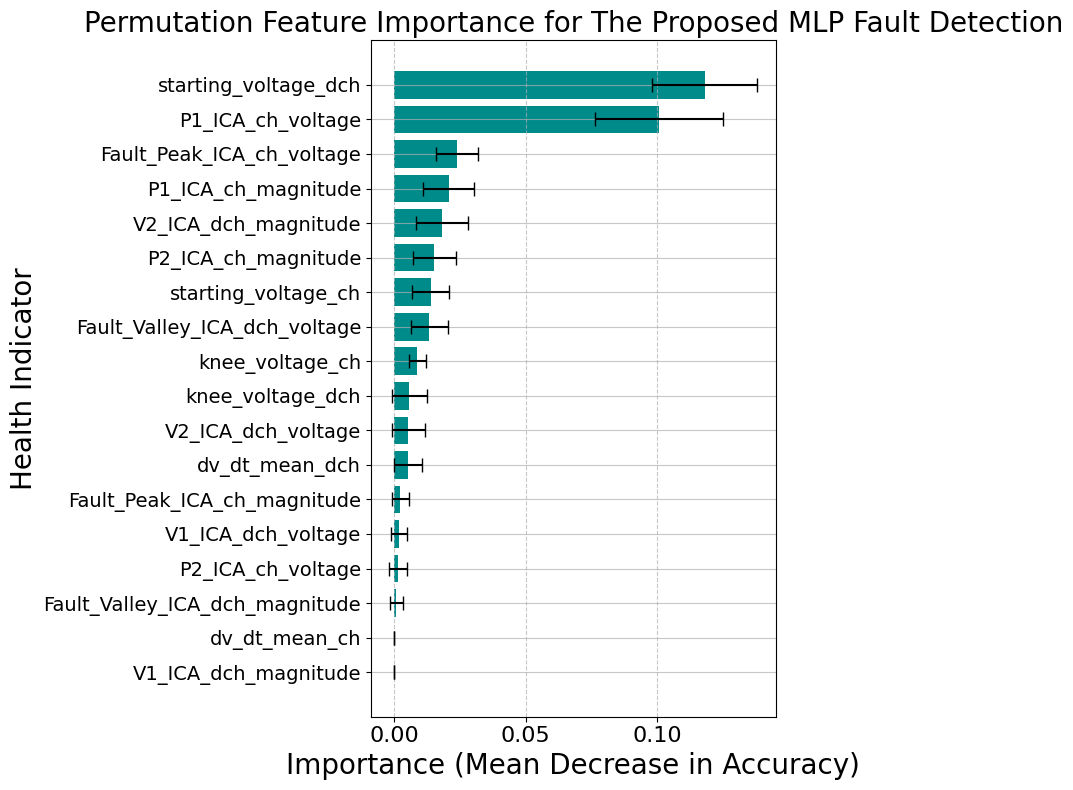

[0.         0.         0.00091324 0.00159817 0.00182648 0.0022831
 0.00525113 0.00547944 0.00570775 0.00890409 0.01347031 0.01392693
 0.01529679 0.01826484 0.02077625 0.0239726  0.10068493 0.11803653]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.inspection import permutation_importance
import tensorflow as tf

print("\n--- Calculating Feature Importance ---")
def keras_scorer(model, X, y):
    _, accuracy = model.evaluate(X, y, verbose=0)
    return accuracy

result = permutation_importance(
    model, 
    X_test_scaled, 
    y_test, 
    scoring=keras_scorer, 
    n_repeats=30, 
    random_state=42, 
    n_jobs=-1
)

sorted_idx = result.importances_mean.argsort()
feature_names = np.array(X.columns)

plt.style.use('default')
fig, ax = plt.subplots(figsize=(8, 8))
ax.barh(
    feature_names[sorted_idx],
    result.importances_mean[sorted_idx],
    xerr=result.importances_std[sorted_idx],
    align='center',
    capsize=5,
    color='darkcyan',
    ecolor='black',
)
ax.set_title("Permutation Feature Importance for The Proposed MLP Fault Detection", fontsize=20)
ax.set_xlabel("Importance (Mean Decrease in Accuracy)", fontsize=20)
ax.set_ylabel("Health Indicator", fontsize=20)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=14)
ax.grid(axis='x', linestyle='--', alpha=0.7)
ax.grid(axis='y', linestyle='-', alpha=0.7)
plt.tight_layout()
plt.show()

print(result.importances_mean[sorted_idx])

# Part 2: Paper Visualizations

## 1. Degradation Analysis
The plot below illustrates the discharge capacity fade over time.

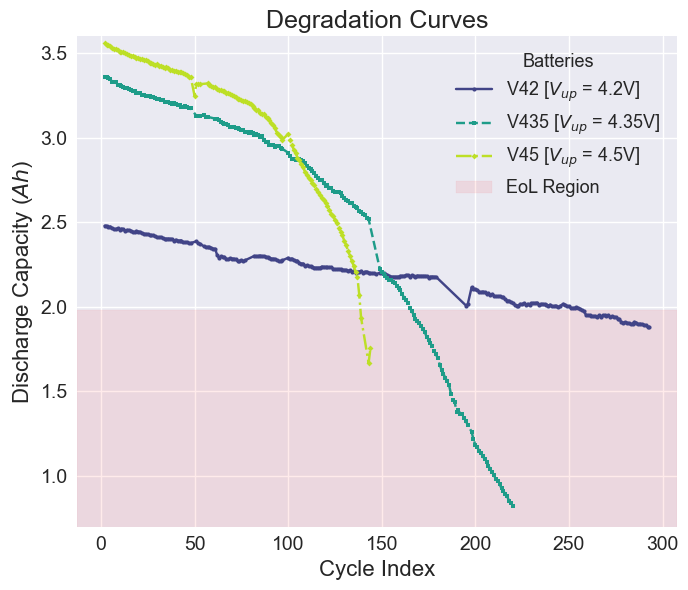

In [ ]:
mode = ['dch_cap', 1, 32]

plt.style.use('seaborn-v0_8')
plt.figure(figsize=(7, 6))
markersize = 3

markers = ['o', 's', 'D', '^', 'v', 'x', '+', '.']
linestyles = ['-', '--', '-.']

Condition = ['V42 [$V_{up}$ = 4.2V]', 
             'V435 [$V_{up}$ = 4.35V]', 
             'V45 [$V_{up}$ = 4.5V]']

batteries = [V42B, V435B, V45A]
EoL = [300, 300, 300]
colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(batteries))) 
C_init = np.float64(1)
Cond = Condition
Cells = batteries

for i in range(len(Cells)):
    Visualizer = reloader_vis()(Cells[i])
    Visualizer.plot_degradation(
        mode, C_initial=C_init,
        marker=markers[i], markersize=markersize,
        linestyle=linestyles[i],
        color=colors[i], label=Cond[i], EoL=EoL[i]
    )

plt.axhspan(
    0, 0.8 * batteries[0]['ch_cap'][1], 
    color='red', alpha=0.08, label='EoL Region'
)

# Axis formatting
fs_label = 16       # Axis labels
fs_ticks = 14       # Axis tick numbers
fs_title = 18       # Plot title
fs_legend = 13      # Legend text
plt.xticks(fontsize=fs_ticks)
plt.yticks(fontsize=fs_ticks)

# Legend outside the plot
plt.legend(
    title='Batteries', loc='upper right',
    prop={'size': fs_legend}, title_fontsize=fs_legend
)

plt.xlabel('Cycle Index', fontsize=fs_label)
if mode[0] == 'dch_cap':
    plt.ylabel('Discharge Capacity ($Ah$)', fontsize=fs_label)
else:
    plt.ylabel('Charge Capacity ($Ah$)', fontsize=fs_label)

plt.ylim([0.7,3.6])
plt.title('Degradation Curves', fontsize=fs_title)
plt.tight_layout()
plt.show()

## 2. Evolution of Incremental Capacity (ICA) Curves

In [ ]:
cell_data = V45A
cell_label = 'V45'
cycles_to_plot = [1, 20, 50, 80, 120]

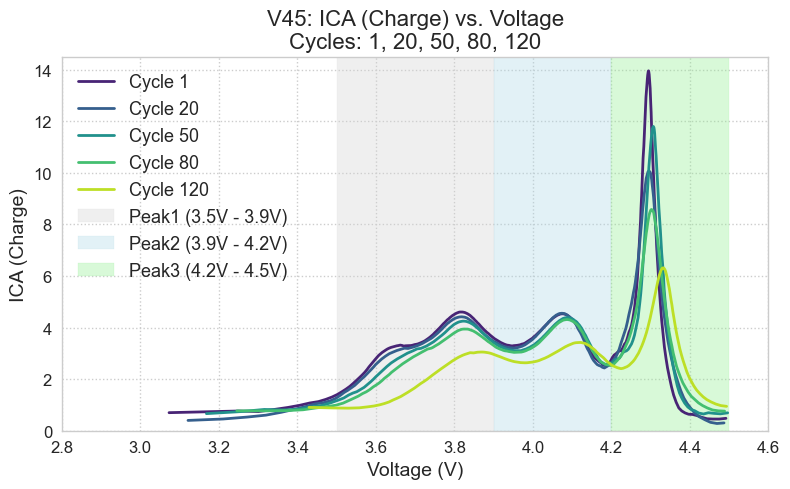

In [ ]:
plt.style.use('seaborn-v0_8-whitegrid')

# Primary measurement settings
measurement = 'ICA'  
ch_dch = 'ch'     

# Choose the variable for the x-axis ('Voltage' or 'Time')
x_axis_variable = 'Voltage' #'Voltage'

# Secondary measurement settings
use_second_measurement = False
measurement2 = 'Temperature'
ch_dch_2 = 'ch'
independent_second_axis = True # Set to False to plot on the same y-axis

norm_on = False      # Normalize y-axis data to a [0, 1] range
type_ch, type_dch = 'Original_ch', 'Original_dch'


def normalize(data):
    """Normalizes a numpy array to the range [0, 1]."""
    data = np.array(data)
    return np.zeros_like(data) if np.max(data) == np.min(data) else (data - np.min(data)) / (np.max(data) - np.min(data))

def get_data(cell, y_axis_key, cycle, ch_dch_flag, x_axis_key):
    """Retrieves and optionally normalizes data for a given cycle."""
    data_source_type = type_dch if ch_dch_flag == 'dch' else type_ch
    
    y_data_raw = cell[data_source_type][y_axis_key][cycle]
    y_data = normalize(y_data_raw) if norm_on else y_data_raw
    
    x_data = cell[data_source_type][x_axis_key][cycle]
    
    return y_data, x_data


# Define the ICA valley voltage windows
charge_ica_windows = {
    'Peak1 (3.5V - 3.9V)': (3.5, 3.9),
    'Peak2 (3.9V - 4.2V)': (3.9, 4.2),
    'Peak3 (4.2V - 4.5V)': (4.2, 4.5),
}

fig, ax1 = plt.subplots(figsize=(8, 5))
ax2 = ax1.twinx() if use_second_measurement and independent_second_axis else ax1

num_cycles = len(cycles_to_plot)
colors = plt.cm.viridis(np.linspace(0.1, 0.9, num_cycles))

for i, cycle in enumerate(cycles_to_plot):
    color = colors[i]

    y1, x1 = get_data(cell_data, measurement, cycle, ch_dch, x_axis_variable)
    ax1.plot(x1, y1, label=f'Cycle {cycle}', color=color, lw=2)

    if use_second_measurement:
        y2, x2 = get_data(cell_data, measurement2, cycle, ch_dch_2, x_axis_variable)
        ax2.plot(x2, y2, label=f'Cycle {cycle}', color=color, lw=2, ls='--')

valley_colors = ['lightgrey', 'lightblue', 'lightgreen']

for (valley_name, (v_min, v_max)), color in zip(charge_ica_windows.items(), valley_colors):
    ax1.axvspan(v_min, v_max, alpha=0.35, color=color, label=valley_name)

fs = 14
x_unit = '(V)' if x_axis_variable == 'Voltage' else '(s)'
ax1.set_xlabel(f'{x_axis_variable} {x_unit}', fontsize=fs)
ch_dch_label = 'Charge' if ch_dch == 'ch' else 'Discharge'
ax1.set_ylabel(f'{measurement} ({ch_dch_label})', fontsize=fs)

if use_second_measurement and independent_second_axis:
    ch_dch_label_2 = 'Charge' if ch_dch_2 == 'ch' else 'Discharge'
    ax2.set_ylabel(f'{measurement2} ({ch_dch_label_2})', fontsize=fs)
elif use_second_measurement:
    ax1.set_ylabel(f"{measurement} & {measurement2}", fontsize=fs)

title = f'{cell_label}: {measurement} ({ch_dch_label})'
if use_second_measurement:
    title += f' & {measurement2} ({ch_dch_label_2})'
title += f' vs. {x_axis_variable}\nCycles: {", ".join(map(str, cycles_to_plot))}'
ax1.set_title(title, fontsize=fs+2)

ax1.grid(True, linestyle=':')
ax1.tick_params(axis='both', which='major', labelsize=fs-2)
if use_second_measurement and independent_second_axis:
    ax2.tick_params(axis='both', which='major', labelsize=fs-2)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels() if use_second_measurement else ([], [])

ax1.legend(lines1 , labels1, loc='upper left',
    prop={'size': fs_legend}, title_fontsize=fs_legend
)

ax1.set_xlim([2.8, 4.6])
ax1.set_ylim([0, 14.5])

plt.tight_layout()
plt.show()

## 3. Tracking Feature Trajectories
We use the `DegradationAnalyzer` to visualize how specific ICA peaks evolve over the battery's life.
* **Left Shift (Voltage):** Indicates increasing internal resistance (Impedance rise).
* **Amplitude Decay:** Indicates Loss of Active Material (LAM).

DegradationAnalyzer initialized.
Analyzing 135 cycles for ICA valleys during Discharge...


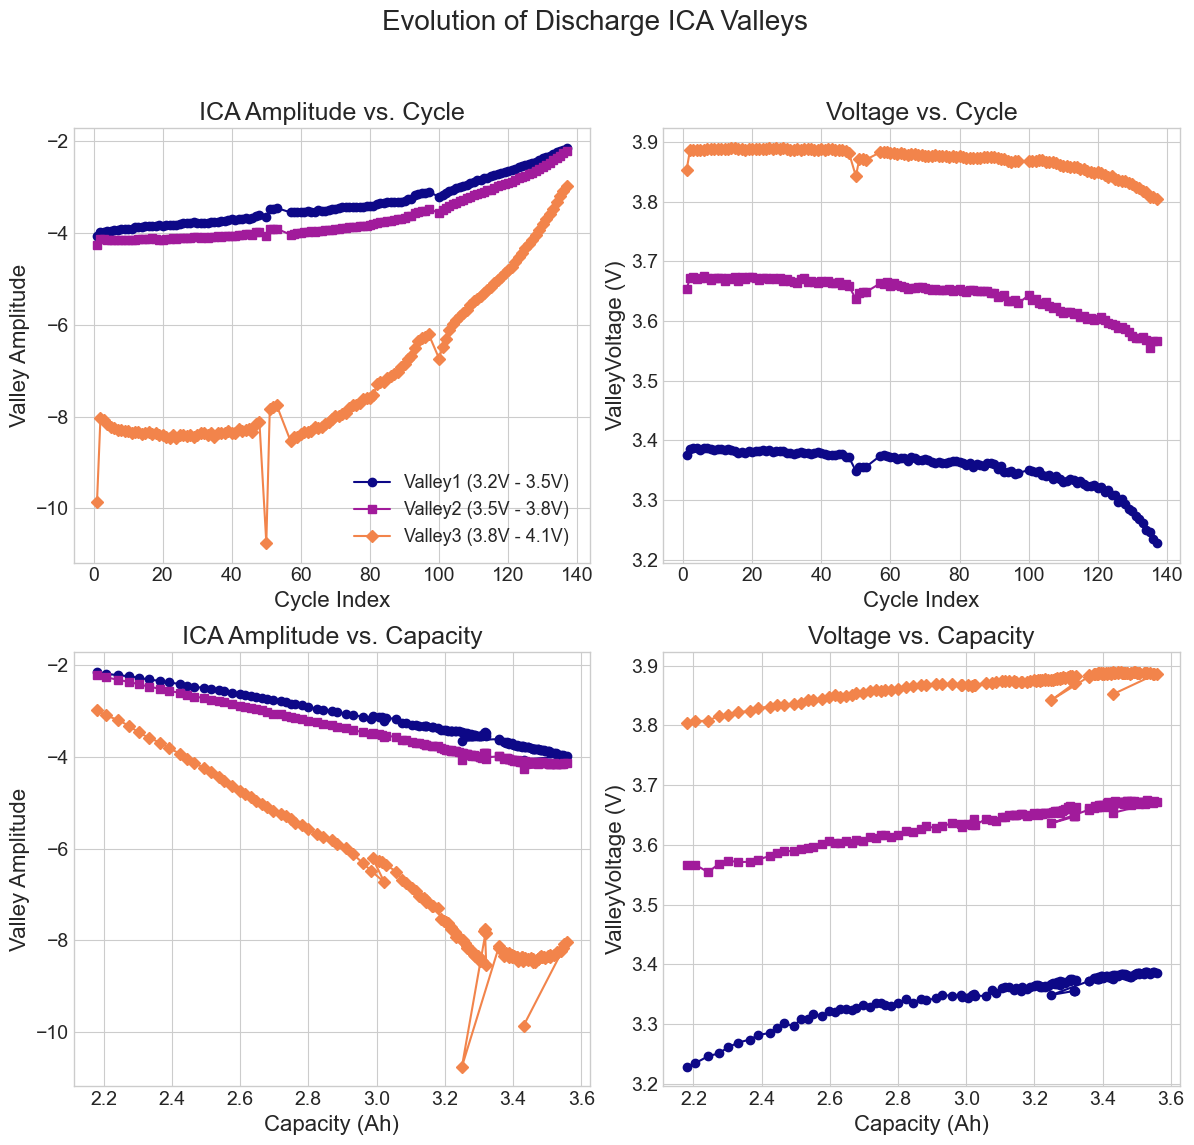

DegradationAnalyzer initialized.
Analyzing 135 cycles for ICA peaks during Charge...


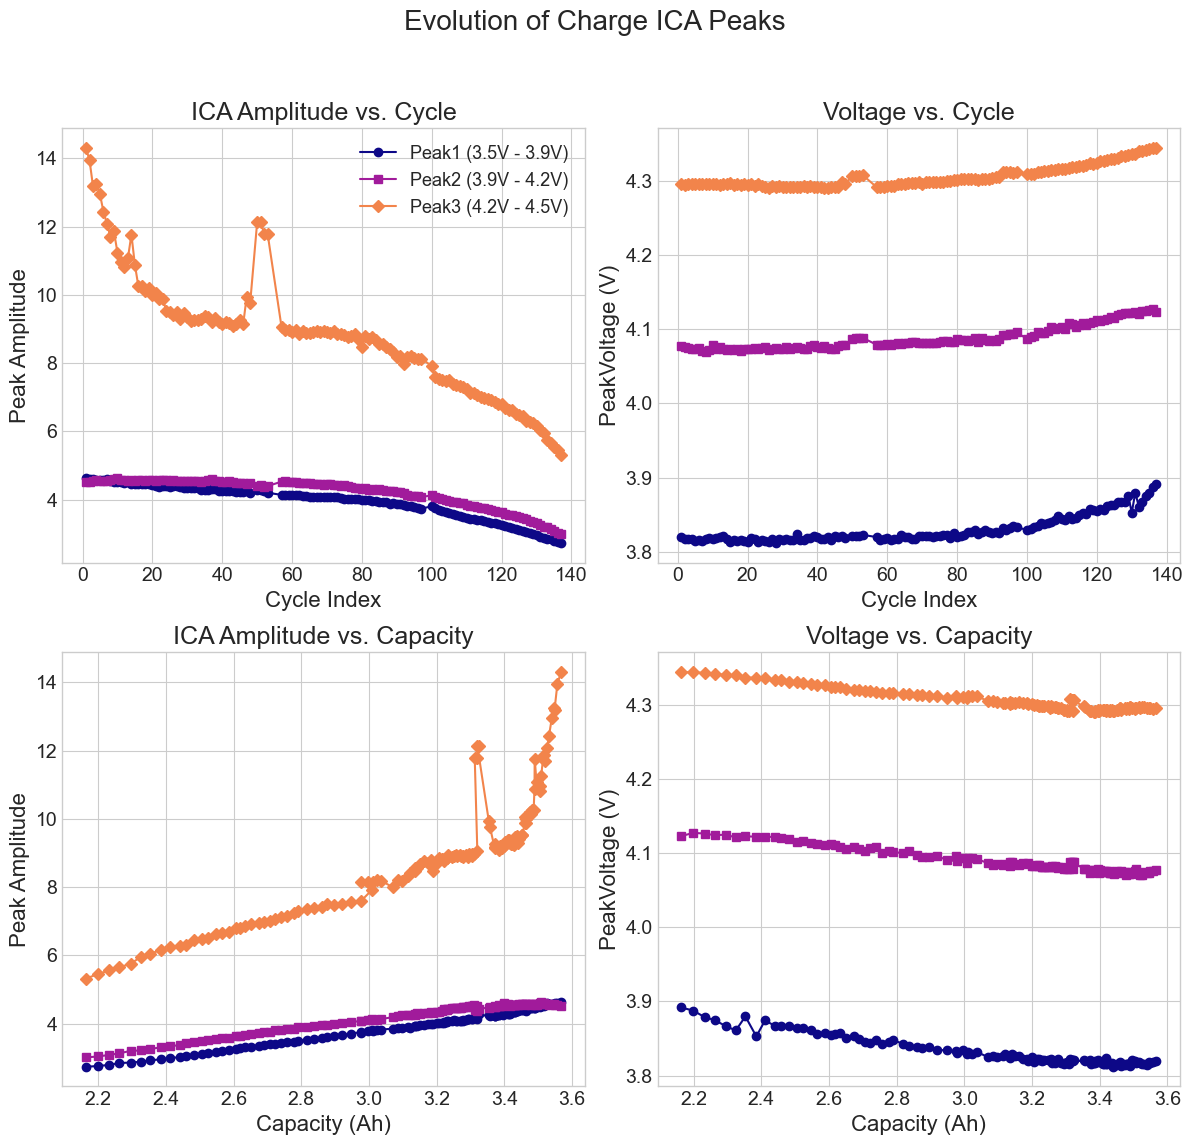

In [74]:
def reloader_analyzer():
    importlib.reload(BatteryDataToolkit)
    return BatteryDataToolkit.DegradationAnalyzer

# Select the battery data to analyze
cell_to_analyze = V45A

# 1. Initialize the analyzer
analyzer = reloader_analyzer()(cell_to_analyze)

# 2. Define parameters for ICA Charge Peak analysis
# These voltage windows and prominence values are typical starting points for NMC/NCA cells.
# You will likely need to adjust them by inspecting your ICA curves to match your specific battery chemistry.
charge_ica_windows = {
    'Valley1 (3.2V - 3.5V)': (3.2, 3.5),
    'Valley2 (3.5V - 3.8V) ': (3.5, 3.7),
    'Valley3 (3.8V - 4.1V) ': (3.7, 4.0)
}
peak_params = {'prominence': 0.1} 

charge_ica_peaks = analyzer.find_features(
    feature_type='ICA', 
    charge_discharge='Discharge', 
    find='valleys',
    voltage_windows=charge_ica_windows,
    peak_params=peak_params
)

# 4. Plot the results
if charge_ica_peaks:
    analyzer.plot_feature_evolution(charge_ica_peaks,mode='Valley', feature_name="Discharge ICA Valleys", cycle_start = 1, cycle_end = 137)

# 1. Initialize the analyzer
analyzer = reloader_analyzer()(cell_to_analyze)

# 2. Define parameters for ICA Charge Peak analysis
# These voltage windows and prominence values are typical starting points for NMC/NCA cells.
# You will likely need to adjust them by inspecting your ICA curves to match your specific battery chemistry.
charge_ica_windows = {
    'Peak1 (3.5V - 3.9V)': (3.5, 3.9),
    'Peak2 (3.9V - 4.2V)': (3.9, 4.2),
    'Peak3 (4.2V - 4.5V)': (4.2, 4.5),
}
peak_params = {'prominence': 0.1} 

# 3. Find the features (ICA Charge Peaks)
charge_ica_peaks = analyzer.find_features(
    feature_type='ICA', 
    charge_discharge='Charge', 
    find='peaks',
    voltage_windows=charge_ica_windows,
    peak_params=peak_params
)

# 4. Plot the results
if charge_ica_peaks:
    analyzer.plot_feature_evolution(charge_ica_peaks, mode='Peak', feature_name="Charge ICA Peaks", cycle_start = 1, cycle_end = 137)

